In [1]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
from sklearn.datasets import make_blobs
from plotnine import *   
# StandardScaler is a function to normalize the data 
# You may also check MinMaxScaler and MaxAbsScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN


from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.mixture import GaussianMixture

import sklearn.metrics as met

import scipy
from scipy import spatial as sp

%matplotlib inline
import plotly.figure_factory as ff

In [2]:
#import graphlab as gl
import numpy as np
import matplotlib.pyplot as plt 
import copy
from scipy.stats import multivariate_normal

%matplotlib inline

'''Check GraphLab Create version'''
from distutils.version import StrictVersion
#assert (StrictVersion(gl.version) >= StrictVersion('1.8.5')), 'GraphLab Create must be version 1.8.5 or later.'

In [3]:
from sklearn.decomposition import PCA

In [4]:
from scipy.cluster.hierarchy import dendrogram

Clustering Functions:

In [5]:
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmykrgykm'  #List colors
    alpha = 0.5  #color obaque
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [6]:
#helper function to display data after DBScan Clustering
def display_DBScan(labels,db,data,eps,min_samples):
    X=data
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )
        silScore=(met.silhouette_score(data, labels, metric = 'euclidean'))
        title="eps="+str(eps) + " n_samples=" + str(min_samples) + " Est.no.of clusters= "+ str(n_clusters_)+" SilScore= "+ str(silScore)
        plt.title(title)
    #plt.show()

In [7]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll


In [8]:
def compute_responsibilities(data, weights, means, covariances):
    '''E-step: compute responsibilities, given the current parameters'''
    num_data = len(data)
    num_clusters = len(means)
    resp = np.zeros((num_data, num_clusters))
    
    # Update resp matrix so that resp[i,k] is the responsibility of cluster k for data point i.
    # Hint: To compute likelihood of seeing data point i given cluster k, use multivariate_normal.pdf.
    for i in range(num_data):
        for k in range(num_clusters): 
            resp[i, k] = multivariate_normal.pdf(data[i], mean=means[k], cov=covariances[k])*weights[k]
    
    # Add up responsibilities over each data point and normalize
    row_sums = resp.sum(axis=1)[:, np.newaxis]
    resp = resp / row_sums
    
    return resp

In [9]:
def compute_soft_counts(resp):
    # Compute the total responsibility assigned to each cluster, which will be useful when 
    # implementing M-steps below. In the lectures this is called N^{soft}
    counts = np.sum(resp, axis=0)
    return counts

In [10]:
def compute_weights(counts):
    num_clusters = len(counts)
    weights = [0.] * num_clusters
    N = np.sum(counts)  
    
    for k in range(num_clusters):
        # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
        # HINT: compute # of data points by summing soft counts. 
        weights[k] = counts[k]/N

    return weights

In [11]:
def compute_means(data, resp, counts):
    num_clusters = len(counts)
    num_data = len(data)
    means = [np.zeros(len(data[0]))] * num_clusters 
    
    for k in range(num_clusters):
        # Update means for cluster k using the M-step update rule for the mean variables.
        # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
        weighted_sum = 0.
        
        for i in range(num_data): 
            weighted_sum += resp[i][k] * data[i]
        
        nk_soft = counts[k]
        means[k] = (1/nk_soft)*weighted_sum

    return means

In [12]:
def compute_covariances(data, resp, counts, means):
    num_clusters = len(counts)
    num_dim = len(data[0])
    num_data = len(data)
    covariances = [np.zeros((num_dim,num_dim))] * num_clusters
    
    for k in range(num_clusters):
        # Update covariances for cluster k using the M-step update rule for covariance variables.
        # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
        weighted_sum = np.zeros((num_dim, num_dim))
        for i in range(num_data):
            # (Hint: Use np.outer on the data[i] and this cluster's mean) 
            xi,uk = data[i], means[k]
            weighted_sum += resp[i][k]* np.outer(xi-uk,xi-uk)
        
        nk_soft = counts[k]
        covariances[k] =(1/nk_soft)*weighted_sum

    return covariances

In [13]:
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                 mux=0.0, muy=0.0, sigmaxy=0.0):
    """
    Bivariate Gaussian distribution for equal shape *X*, *Y*.
    See `bivariate normal
    <http://mathworld.wolfram.com/BivariateNormalDistribution.html>`_
    at mathworld.
    """
    Xmu = X-mux
    Ymu = Y-muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

In [14]:
import matplotlib.mlab as mlab
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo','orange','yellow','blue']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

In [15]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for it in range(maxiter):
        if it % 5 == 0:
            print("Iteration %s" % it)
        
        
        resp = compute_responsibilities(data, weights, means, covariances)

        counts = compute_soft_counts(resp)
        
        weights = compute_weights(counts)
        
        means = compute_means(data, resp, counts)
        
        covariances = compute_covariances(data, resp, counts, means)
        
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if it % 5 != 0:
        print("Iteration %s" % it)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

In [16]:
#function to perform K-Means Clustering and save silhouette scores and distortions 
def KMeansClustering_euclidean(data,K):
    n = range(2,K+1)
    distortions=[]
    silScore=[]
    clustersArray=[]
    modelArray=[]
    for i in n:
        km = KMeans(n_clusters=i)
        km=km.fit(data)
        modelArray.append(km)
        distortions.append(sum(np.min(sp.distance.cdist(data,
            km.cluster_centers_, 'euclidean'),axis=1)) /
            data.shape[0])
        labels = km.labels_
        silScore.append(met.silhouette_score(data, labels, metric = 'euclidean'))
        clustersArray.append(km)
        #plt.subplot(2,5, i-1)
        #display_cluster(data,km,i)
        #title='K='+str(i)
        #plt.title(title)
    return distortions,silScore,clustersArray,modelArray

In [17]:
def KMeansClustering_manhattan(data,K):
    n = range(2,K+1)
    distortions=[]
    silScore=[]
    clustersArray=[]
    modelArray=[]
    for i in n:
        km = KMeans(n_clusters=i,init='random')
        km=km.fit(data)
        modelArray.append(km)
        distortions.append(sum(np.min(sp.distance.cdist(data,
            km.cluster_centers_, 'euclidean'),axis=1)) /
            data.shape[0])
        labels = km.labels_
        silScore.append(met.silhouette_score(data, labels, metric = 'manhattan'))
        clustersArray.append(km)
        #plt.subplot(2,5, i-1)
        #display_cluster(data,km,i)
        #title='K='+str(i)
        #plt.title(title)
    return distortions,silScore,clustersArray,modelArray

In [18]:
def aggloClustering_euc(data,n_clusters):
    silhouette_avg=[]
    for i in range(2, n_clusters+1):
        agg = AgglomerativeClustering(n_clusters=i,affinity='euclidean',compute_distances=True,linkage='ward')
        agg_labels = agg.fit_predict(data)
       # plt.subplot(2,5, i-1)
      #  plt.figure(figsize=(10, 5))
       # plot_dendrogram(agg)
       # dendrogram(agg.linkage_, leaf_font_size=8)
        title='n_clusters='+str(i) + 'Sil_Score=' +str(met.silhouette_score(data, agg_labels))
        #plt.title(title)
        silhouette_avg.append(met.silhouette_score(data, agg_labels,metric = 'euclidean'))
    plt.figure(figsize=(10, 5))
    plot_dendrogram(agg)
    return silhouette_avg

In [19]:
def aggloClustering_man(data,n_clusters):
    silhouette_avg=[]
    for i in range(2, n_clusters+1):
        agg = AgglomerativeClustering(n_clusters=i,compute_distances=True,affinity='manhattan',linkage='complete')
        agg_labels = agg.fit_predict(data)
       # plt.subplot(2,5, i-1)
       # plt.figure(figsize=(10, 5))
       # plot_dendrogram(agg)
       # dendrogram(agg.linkage_, leaf_font_size=8)
        title='n_clusters='+str(i) + 'Sil_Score=' +str(met.silhouette_score(data, agg_labels))
       # plt.title(title)
        silhouette_avg.append(met.silhouette_score(data, agg_labels,metric = 'manhattan'))
    plt.figure(figsize=(10, 5))
    plot_dendrogram(agg)
    return silhouette_avg

In [20]:
def plot_dendrogram(model, **kwargs):
        # Create linkage matrix and then plot the dendrogram
        # create the counts of samples under each node
        counts = np.zeros(model.children_.shape[0])
        n_samples = len(model.labels_)
        for i, merge in enumerate(model.children_):
            current_count = 0
            for child_idx in merge:
                if child_idx < n_samples:
                    current_count += 1  # leaf node
                else:
                    current_count += counts[child_idx - n_samples]
                    counts[i] = current_count
                    
        linkage_matrix = np.column_stack([model.children_, model.distances_,
                                          counts]).astype(float)

        # Plot the corresponding dendrogram
        dendrogram(linkage_matrix, **kwargs)
        #plt.show()
          

In [21]:
def DBSCAN_Clustering2(data,eps,nsamples):  
    db = DBSCAN(eps=eps, min_samples=nsamples)
    db.fit(data)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters_ >1:
        silScore=met.silhouette_score(data, labels, metric = 'euclidean')
    else:
        silScore=0
    n_noise_ = list(labels).count(-1)
   # display_DBScan(labels,db,data,eps,nsamples)
    return silScore,n_noise_

In [22]:
def DBSCAN_Clustering(data,eps_start,eps_stop,eps_step,nsamples_start,nsamples_stop,nsamples_step):
    df = pd.DataFrame(columns=["epsilon", "n_samples","n_clusters","silScore","n_noise"])
    runs=0;
    epsList=np.arange(eps_start,eps_stop,eps_step)
    for i in range(len(epsList)):
        for nsamples in range (nsamples_start,nsamples_stop,nsamples_step):
            runs=runs+1
            db = DBSCAN(eps=epsList[i], min_samples=nsamples,metric = 'manhattan')
            db.fit(data)
            labels = db.labels_
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters_ >1:
                silScore=met.silhouette_score(data, labels, metric = 'manhattan')
            else:
                silScore=0
            n_noise_ = list(labels).count(-1)
            df.loc[runs]=[epsList[i],nsamples,n_clusters_,silScore,n_noise_]                 
    return df

.

# Multi-Blob Dataset:

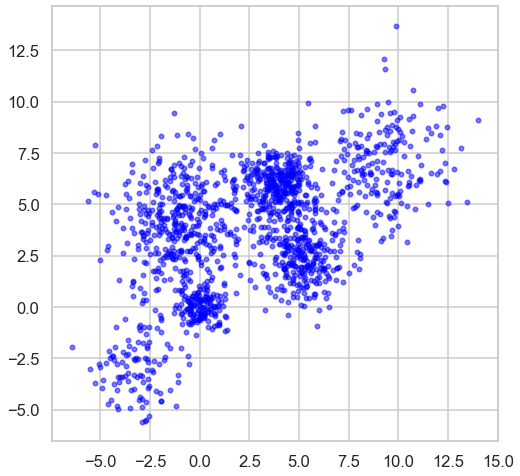

In [23]:
plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")
sns.set_context("talk")

n_bins = 6  
centers = [(-3, -3), (0, 0), (5,2.5),(-1, 4), (4, 6), (9,7)]
Multi_blob_Data, y = make_blobs(n_samples=[100,150, 300, 400,300, 200], n_features=2, cluster_std=[1.3,0.6, 1.2, 1.7,0.9,1.7],
                  centers=centers, shuffle=False, random_state=42)
display_cluster(Multi_blob_Data)

### K-Means Clustering:

In [24]:
K=9
n = range(2,K+1)
distFunc_Km_euc,silScore_Km_euc,clustersArray_Km_euc,km_euc=KMeansClustering_euclidean(Multi_blob_Data,K)
distFunc_Km_man,silScore_Km_man,clustersArray_Km_man,km_man=KMeansClustering_manhattan(Multi_blob_Data,K)

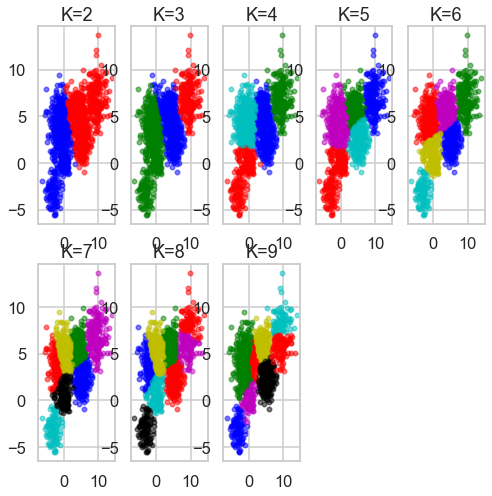

In [25]:
for i in n:
    plt.subplot(2,5, i-1)
    display_cluster(Multi_blob_Data,km_euc[i-2],i)
    title='K='+str(i)
    plt.title(title)

Text(0.5, 1.0, 'distFn: manhattan distance')

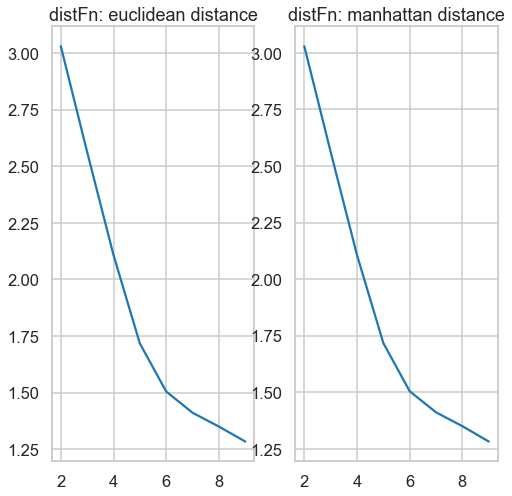

In [26]:
plt.subplot(1,2,1)
plt.plot(n,distFunc_Km_euc)
plt.title("distFn: euclidean distance")
plt.subplot(1,2,2)
plt.plot(n,distFunc_Km_man)
plt.title("distFn: manhattan distance")

Text(0.5, 1.0, 'silScore: manhattan distance')

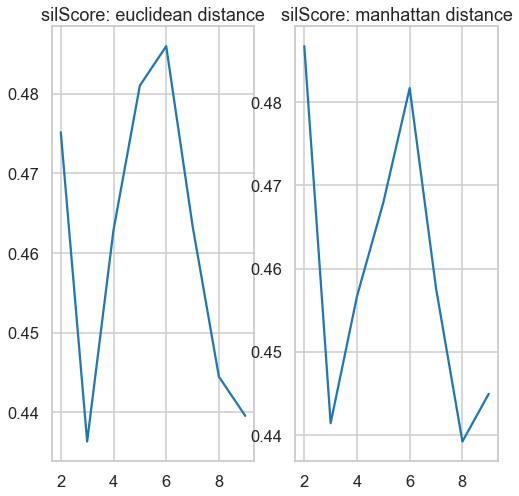

In [27]:
plt.subplot(1,2,1)
plt.plot(n,silScore_Km_euc)
plt.title("silScore: euclidean distance")
plt.subplot(1,2,2)
plt.plot(n,silScore_Km_man)
plt.title("silScore: manhattan distance")

In [28]:
silScore_KM=max(silScore_Km_euc)
silScore_Km_euc.index(max(silScore_Km_euc))+2

6

### DBSCAN:

In [29]:
df_DBSCAN=DBSCAN_Clustering(Multi_blob_Data,eps_start=0.1,eps_stop=3,eps_step=0.05,nsamples_start=5,nsamples_stop=25,nsamples_step=1)
df_DBSCAN.to_csv("DBSCAN_Results_multiblob.csv", index=False)
max_silScore_row = df_DBSCAN.iloc[df_DBSCAN['silScore'].idxmax()]
print(max_silScore_row)

epsilon        1.350000
n_samples     21.000000
n_clusters     2.000000
silScore       0.288479
n_noise       65.000000
Name: 517, dtype: float64


### Agglomerative Clustering:

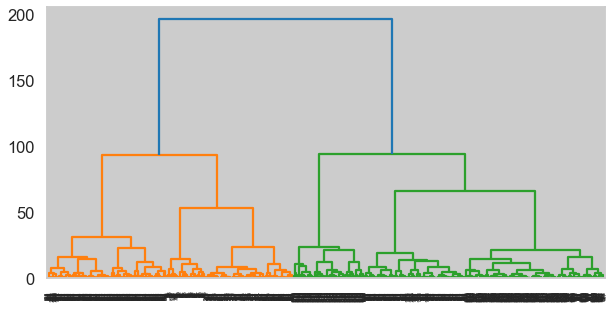

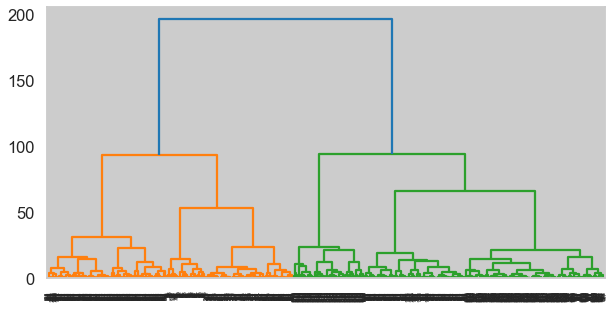

In [30]:
n_clusters=9
silScore_agg_euc=aggloClustering_euc(Multi_blob_Data,n_clusters)
silScore_agg_man=aggloClustering_euc(Multi_blob_Data,n_clusters)

Text(0.5, 1.0, 'silScore: euclidean distance')

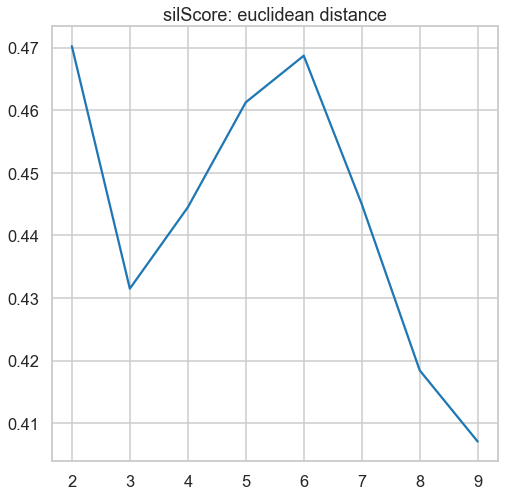

In [31]:
n = range(2,n_clusters+1)
silScore_AGG=max(silScore_agg_euc)
plt.plot(n,silScore_agg_euc)
plt.title("silScore: euclidean distance")

### GMM:

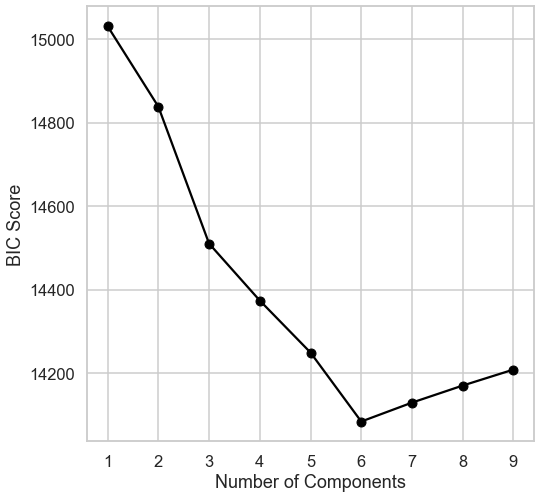

In [32]:
n_components_range = range(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Multi_blob_Data) for n in n_components_range]
bic_scores = [m.bic(Multi_blob_Data) for m in models]
plt.plot(n_components_range, bic_scores, '-o', color='black')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.show()

In [33]:
gmm = GaussianMixture(n_components=6)
gmm.fit(Multi_blob_Data)
labels = gmm.predict(Multi_blob_Data)
silScore_GMM=met.silhouette_score(Multi_blob_Data,labels, metric = 'euclidean')
silScore_GMM

0.45347238469136353

##### Comparison between clustering algorithms:

In [34]:
print("Silhouette score using K-Means = " + str(silScore_KM))
print("Silhouette score using DBSCAN = " + str(0))
print("Silhouette score using Agglomerative Clustering = " + str(silScore_AGG))
print("Silhouette score using GMM = " + str(silScore_GMM))

Silhouette score using K-Means = 0.4859552879172627
Silhouette score using DBSCAN = 0.45347238469136353
Silhouette score using Agglomerative Clustering = 0.4702126931832277
Silhouette score using GMM = 0


# Customer Dataset:

#### Extracting and normalising data:

In [35]:
df_customer = pd.read_csv("Customer data.csv",index_col=0)
customers_data = df_customer.select_dtypes(include=[np.number]).values
scaler = StandardScaler()
scaler.fit(df_customer)
scaled_data = scaler.transform(df_customer)
df_scaled = pd.DataFrame(scaled_data, columns=df_customer.columns)
customers_data_scaled = df_scaled.select_dtypes(include=[np.number]).values

#### Selecting the optimum number of dimensions :

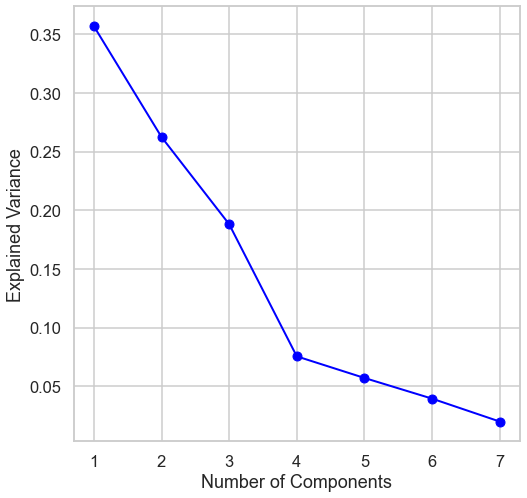

In [36]:
pca = PCA()
pca.fit(customers_data_scaled)
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, 'bo-', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

#### Performing PCA :

In [37]:
pca = PCA(n_components=4)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

### K-Means Clustering:

In [38]:
K=6
n = range(2,K+1)
distFunc_Km_euc,silScore_Km_euc,clustersArray_Km_euc,km_euc=KMeansClustering_euclidean(pca_data,K)
distFunc_Km_man,silScore_Km_man,clustersArray_Km_man,km_man=KMeansClustering_manhattan(pca_data,K)

Text(0.5, 1.0, 'distFn: manhattan distance')

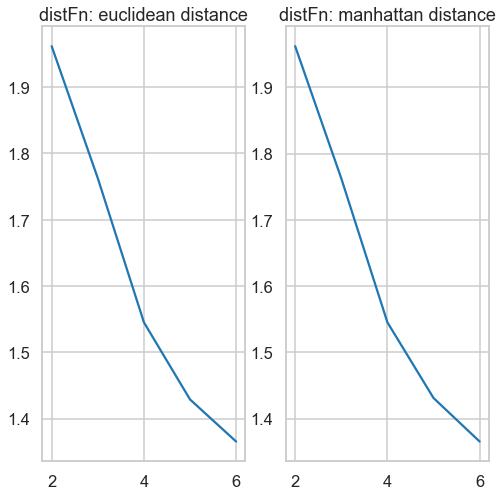

In [39]:
plt.subplot(1,2,1)
plt.plot(n,distFunc_Km_euc)
plt.title("distFn: euclidean distance")
plt.subplot(1,2,2)
plt.plot(n,distFunc_Km_man)
plt.title("distFn: manhattan distance")

Text(0.5, 1.0, 'silScore: manhattan distance')

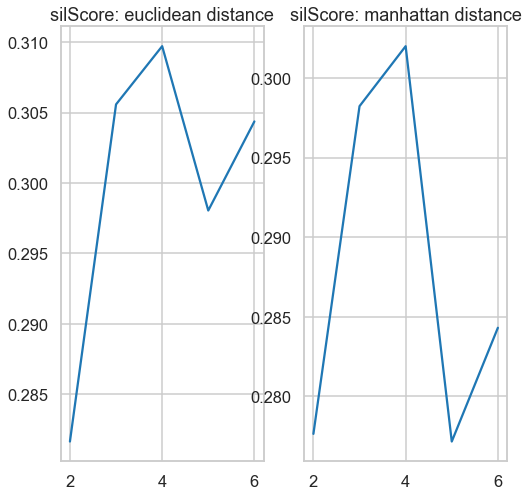

In [40]:
plt.subplot(1,2,1)
plt.plot(n,silScore_Km_euc)
plt.title("silScore: euclidean distance")
plt.subplot(1,2,2)
plt.plot(n,silScore_Km_man)
plt.title("silScore: manhattan distance")

In [41]:
silScore_KM=max(silScore_Km_euc)
silScore_Km_euc.index(max(silScore_Km_euc))+2

4

In [42]:
silScore_Km_man.index(max(silScore_Km_man))+2

4

### DBSCAN 

In [43]:
df_DBSCAN=DBSCAN_Clustering(pca_data,eps_start=0.1,eps_stop=3,eps_step=0.05,nsamples_start=5,nsamples_stop=25,nsamples_step=1)

df_DBSCAN.to_csv("DBSCAN_Results.csv", index=False)

In [44]:
max_silScore_row = df_DBSCAN.iloc[df_DBSCAN['silScore'].idxmax()]
print(max_silScore_row)

epsilon       2.250000
n_samples     7.000000
n_clusters    2.000000
silScore      0.357143
n_noise       8.000000
Name: 863, dtype: float64


### Agglomerative Clustering :

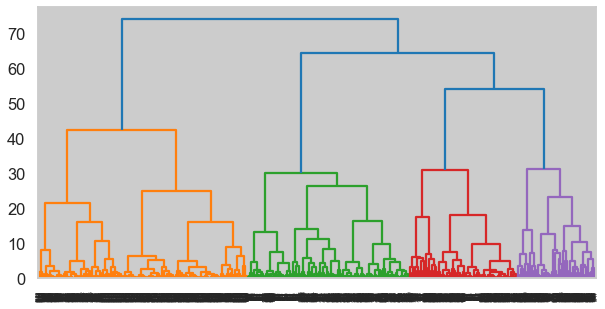

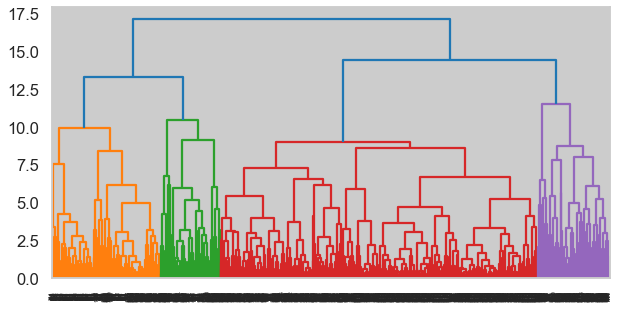

In [45]:
n_clusters=5
silScore_agg_euc=aggloClustering_euc(pca_data,n_clusters)
silScore_agg_man=aggloClustering_man(pca_data,n_clusters)

Text(0.5, 1.0, 'silScore: manhattan distance')

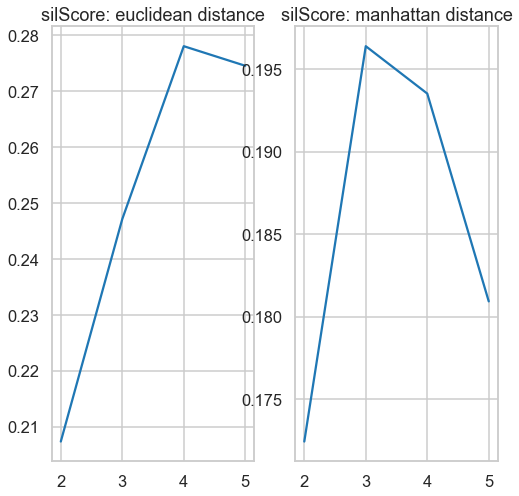

In [46]:
n = range(2,n_clusters+1)
plt.subplot(1,2,1)
plt.plot(n,silScore_agg_euc)
plt.title("silScore: euclidean distance")
plt.subplot(1,2,2)
plt.plot(n,silScore_agg_man)
plt.title("silScore: manhattan distance")

In [47]:
silScore_AGG=max(silScore_agg_euc)
silScore_agg_euc.index(max(silScore_agg_euc))+2

4

### Gaussian Mixture Model:

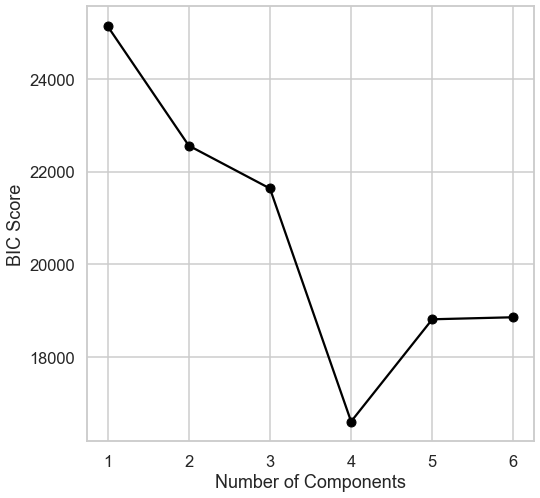

In [48]:
n_components_range = range(1, 7)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(pca_data) for n in n_components_range]
bic_scores = [m.bic(pca_data) for m in models]
plt.plot(n_components_range, bic_scores, '-o', color='black')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.show()

In [49]:
gmm = GaussianMixture(n_components=4)
gmm.fit(pca_data)
labels = gmm.predict(pca_data)
silScore_GMM=met.silhouette_score(pca_data,labels, metric = 'euclidean')
silScore_GMM

0.2807659742290214

##### Comparison between clustering algorithms:
    

In [51]:
print("Silhouette score using K-Means = " + str(silScore_KM))
print("Silhouette score using DBSCAN = " + str(0))
print("Silhouette score using Agglomerative Clustering = " + str(silScore_AGG))
print("Silhouette score using GMM = " + str(silScore_GMM))

Silhouette score using K-Means = 0.30970611416667676
Silhouette score using DBSCAN = 0
Silhouette score using Agglomerative Clustering = 0.2780540346979605
Silhouette score using GMM = 0.2807659742290214
